# Data Augmentation

This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation. You will learn how to apply data augmentation in two ways.

## Import libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Download the Dataset

In [6]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /Users/georgebrockman/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


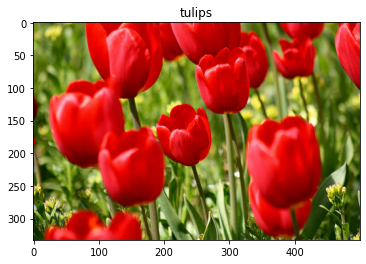

In [8]:
# retrieve an image from the dataset to demonstrate augmentation

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use keras preprocessing

In [9]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

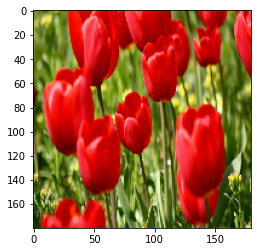

In [10]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [14]:
# verify the pixels are in [0,1]

print("Min and max pixel values:", result.numpy().min(),result.numpy().max())

Min and max pixel values: 0.0 1.0


## Data Augmentation

In [15]:
# use preprocessing layers for data aug

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

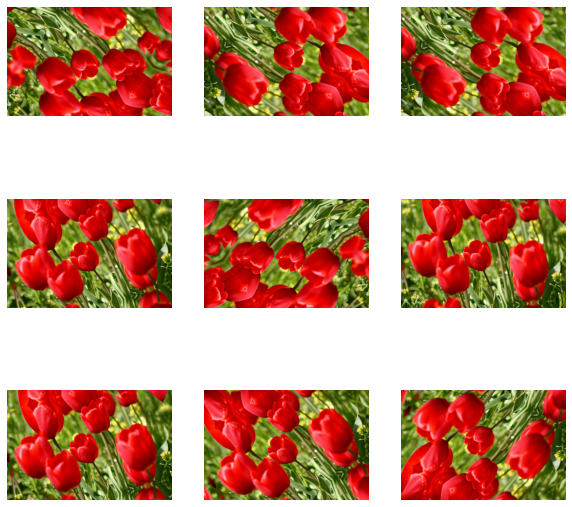

In [17]:
# show augs
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

## Two options to use the preprocessing layers

In [18]:
# option one: make preprocessing layer part of your model

model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

There are **two important** points to be aware of in this option:

- DA will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration
- When you export your model using model.svae, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logice server-side.

**DA is inactive at test time so input images will only be augmented during calls to model.fit(not .evaluate or .predict)

In [19]:
# option two: Apply the preprocessing layers to your dataset

aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use Dataset.map to create a dataset that yields batches of augmented images. In this case:

Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below.
In this case the prepreprocessing layers will not be exported with the model when you call model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

## Apply the preprocessing layers to the datasets

In [21]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Train the Model

In [23]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
# compile the model

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics= ['accuracy'])

In [26]:
# fit the data to the model

epochs = 5
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs)

Epoch 1/5
92/92 [==============================] - 31s 316ms/step - loss: 1.5827 - accuracy: 0.2874 - val_loss: 1.2089 - val_accuracy: 0.4877
Epoch 2/5
92/92 [==============================] - 30s 322ms/step - loss: 1.1193 - accuracy: 0.5478 - val_loss: 1.0657 - val_accuracy: 0.5995
Epoch 3/5
92/92 [==============================] - 30s 319ms/step - loss: 1.0181 - accuracy: 0.6039 - val_loss: 0.9395 - val_accuracy: 0.6376
Epoch 4/5
92/92 [==============================] - 30s 318ms/step - loss: 0.9105 - accuracy: 0.6395 - val_loss: 0.9017 - val_accuracy: 0.6267
Epoch 5/5
92/92 [==============================] - 32s 339ms/step - loss: 0.8845 - accuracy: 0.6467 - val_loss: 0.8424 - val_accuracy: 0.6676


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

## Custom Data Augmentation 

You can also create custom data augmentation layers. 

Method one:

**Create layers.lambda layer** - more concise code

Method two:

**Subclassing** - offers more control

In [27]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [28]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

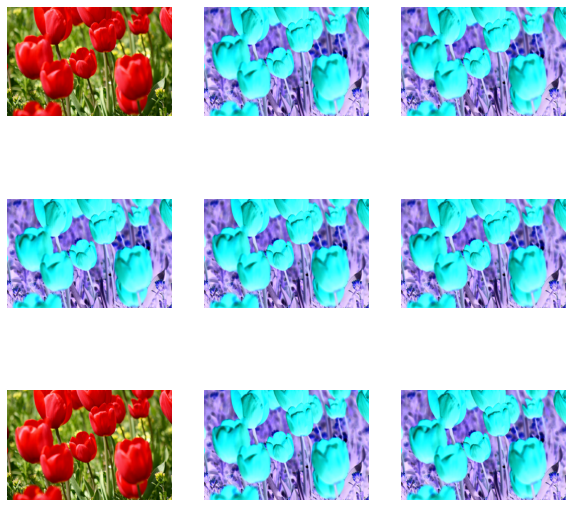

In [29]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
# implement a custom layer by subclassing

class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

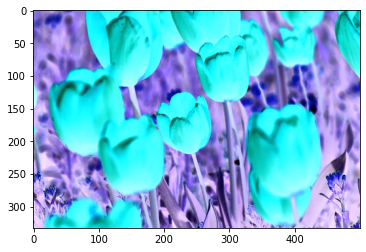

In [33]:
_ = plt.imshow(RandomInvert()(image)[0])

## Using tf.image

For finer control, we can write our own DA pipelines or layers using td.data and tf.image.

Lets first re-import the data as DA was previously configured.

In [34]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

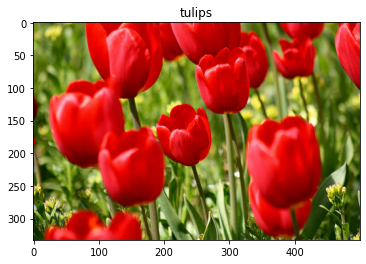

In [35]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [36]:
# compare the original and augmented images side-by-side

def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

## Data Augmentation - Flipping the image

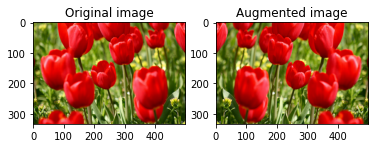

In [37]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

## Grayscale the Image

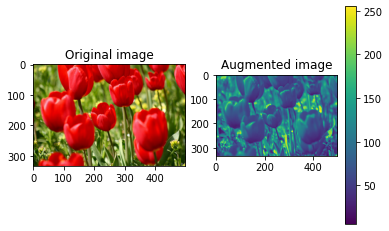

In [38]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

## Saturate the image

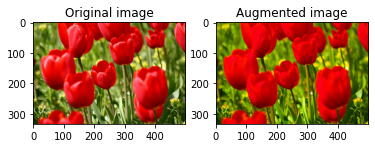

In [39]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

## Change the brightness

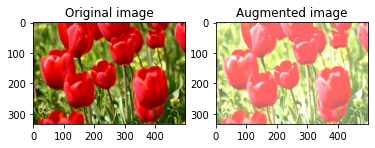

In [40]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

## Adjustments List

Flip the image - .flip_left_right(image)

Grayscale - .rgb_to_grayscale(image)

Saturate - .adjust_saturation(image, 3)

Brightness - .adjust_brightness(image, 0.4)

Central crop - .central_crop(image, central_fraction=0.5)

Rotate 90 degrees - .rot90(image)

## Apply augmentatin to a dataset

In [41]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [42]:
def augment(image,label):
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

## Configure with DATASET

In [43]:
# create the training set

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [44]:
# create the validation set

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [45]:
# create the test set

test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

## Create and train model with new custom augmented data

In [46]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 32s 329ms/step - loss: 1.6224 - accuracy: 0.2966 - val_loss: 1.2511 - val_accuracy: 0.5341
Epoch 2/5
92/92 [==============================] - 29s 311ms/step - loss: 1.1827 - accuracy: 0.5165 - val_loss: 1.0556 - val_accuracy: 0.5913
Epoch 3/5
92/92 [==============================] - 29s 320ms/step - loss: 1.0695 - accuracy: 0.5597 - val_loss: 1.0253 - val_accuracy: 0.6076
Epoch 4/5
92/92 [==============================] - 29s 310ms/step - loss: 0.9745 - accuracy: 0.6042 - val_loss: 0.9561 - val_accuracy: 0.6458
Epoch 5/5
92/92 [==============================] - 28s 309ms/step - loss: 0.8334 - accuracy: 0.6833 - val_loss: 0.9423 - val_accuracy: 0.6294


In [49]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 89ms/step - loss: 0.9328 - accuracy: 0.6267
Accuracy 0.6267030239105225
